
<center>

# **Módulo 3: Análise Temporal e Relações Entre Parâmetros Oceanográficos**

</center>

## Dia 1: Análise de séries temporais e variações sazonais

_**Autores:** Eligio Maure_

---

## Objetivos de Aprendizagem
Ao terminar este notebook, você será capaz de:
* Calcular médias temporais e espaciais (composites);
* Identificar padrões de variação temporal e espacial de uma variável;
* Analisar a co-variação entre duas ou mais variáveis oceanográficas;
* Avaliar os impactos e implicações das variações observadas.

<a id="conteudos"></a>

## Conteúdos
1. [Obter dados online da NASA CMR e avaliar as variações de Rrs (M2D2)](#marazul)
2. [Obter dados online através do Copernicus Marine Toolbox (M2D2)](#download)
3. [Calcular médias temporais e espaciais](#composite)
4. [Variação sazonal e espacial de uma variável](#sazonal)
5. [Extrair séries temporais de um ponto ou área](#series)
7. [Séries temporais de duas variáveis e suas relações](#resolucao)
7. [Análise qualitativa das séries obtidas](#interpretacao)


<!-- Download local -->
<div style="display: flex; align-items: center;">
	<a href="https://github.com/Elgyii/Treinamento-em-Sensoriamento-Remoto-Aplicado-ECOPs-2025/blob/main/modulo3/modulo3d1.ipynb" download>
		<img src="http://yyahn.com/netsci-course/images/download_icon.png"
					style="vertical-align: -8px; margin-right: 10px;" />
		<strong>Baixar o notebook</strong>
	</a>
</div>

<!-- Abrir no Colab -->
<div style="display: flex; align-items: center;">
	<a target="_blank"
			href="https://colab.research.google.com/github/Elgyii/Treinamento-em-Sensoriamento-Remoto-Aplicado-ECOPs-2025/blob/main/modulo3/modulo3d1.ipynb">
		<img src="https://www.tensorflow.org/images/colab_logo_32px.png"
					style="vertical-align: -8px; margin-right: 10px;" />
		<strong>Abrir no Google Colab</strong>
	</a>
</div>

<style>
	table {
		float: left;
	}
</style>

<a id="setup"></a>

## Carregar Bibliotecas

In [1]:
from tqdm.notebook import tqdm
from pathlib import Path

import earthaccess
import copernicusmarine
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

<a id="marazul"></a>

## Obter dados online da NASA CMR e avaliar as variações de Rrs 
- Ver [Módulo 2 Dia 2](https://github.com/Elgyii/Treinamento-em-Sensoriamento-Remoto-Aplicado-ECOPs-2025/blob/main/modulo2/modulo2d2.ipynb)


In [2]:
nasa_auth = earthaccess.login(persist=True)

tspan = ("2023-06-15", "2023-06-15")
bbox = (30, -30, 60, -10)
clouds = (0, 50)

results = earthaccess.search_data(
    short_name="MODISA_L2_OC",
    cloud_hosted=True,
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

directory = Path("L2")
directory.mkdir(exist_ok=True)
earthaccess.download(results, directory)

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

[WindowsPath('L2/AQUA_MODIS.20230615T094500.L2.OC.nc'),
 WindowsPath('L2/AQUA_MODIS.20230615T112500.L2.OC.nc'),
 WindowsPath('L2/AQUA_MODIS.20230615T113000.L2.OC.nc')]

<a id="series"></a>

## Extrair séries de um ponto

In [3]:
def get_data(file, key=None, grp="geophysical_data"): 
	with xr.open_dataset(file, group=grp) as ds:
		data = ds
		if key is not None:
			data = data[key]
	return data

In [4]:
def point_extract(da, lons, lats, lon_center, lat_center, keys, window=3):
	R = 6371
	lon_rad = np.radians(lons)
	lat_rad = np.radians(lats)
	clon_rad = np.radians(lon_center)
	clat_rad = np.radians(lat_center)
	dlon = lon_rad - clon_rad
	dlat = lat_rad - clat_rad
	
	a = np.sin(dlat / 2)**2 + np.cos(lat_rad) * np.cos(clat_rad) * np.sin(dlon / 2)**2
	c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
	dist = R * c
	center = np.where(dist == dist.min())
	mask = np.zeros_like(dist)
	mask[center] = 1
	coords = {'y': range(mask.shape[0]), 'x': range(mask.shape[1])}
	mask = xr.DataArray(mask, dims=('y', 'x'), coords=coords)
	mask = np.bool_(mask.rolling(x=window, y=window, center=True, min_periods=1).max().values)
	
	df = []
	columns = ['lon', 'lat', 'variable', 'pixel_count', 'valid', 'invalid', 
						'min', 'max', 'mean', 'median', 'std', 'pixel_value', 'wavelength']
	for key in keys:
		values = da[key].values
		masked = values[mask]
		cpx = values[center][0]
		valid = np.ma.compressed(masked)
		valid_px = valid.size
		total_px = masked.size
		invalid_px = total_px - valid_px
		mean = valid.mean()
		dstd = valid.std()
		dmax = valid.max()
		dmin = valid.min()
		dmed = np.median(valid)
		df.append([lon_center, lat_center, key, total_px, valid_px, invalid_px, 
						 dmin, dmax, mean, dmed, dstd, cpx, int(key.split('_')[1])])
	return pd.DataFrame(df, columns=columns)


In [5]:
files = list(Path("L2").glob('*.nc'))
file_path = files[1]
lon = get_data(file_path, 'longitude', 'navigation_data')
lat = get_data(file_path, 'latitude', 'navigation_data')
sds = get_data(file_path, 'chlor_a')
ds = get_data(file_path)

In [6]:
keys = ['Rrs_412', 'Rrs_443', 'Rrs_469',
				'Rrs_488', 'Rrs_531', 'Rrs_547', 
				'Rrs_645', 'Rrs_667', 'Rrs_678']

points = {'lon': [32.8, 33.3], 'lat': [-26, -26]} 
inshore = point_extract(ds, lon, lat, points['lon'][0], points['lat'][0], keys)
offshore = point_extract(ds, lon, lat, points['lon'][1], points['lat'][1], keys)
offshore

,lon,lat,variable,pixel_count,valid,invalid,min,max,mean,median,std,pixel_value,wavelength
0,33.3,-26,Rrs_412,9,9,0,0.004046,0.005494,0.004962,0.005082,0.000440,0.005082,412
1,33.3,-26,Rrs_443,9,9,0,0.002914,0.004298,0.003856,0.004004,0.000399,0.004004,443
2,33.3,-26,Rrs_469,9,9,0,0.002596,0.003798,0.003457,0.003626,0.000384,0.003666,469
3,33.3,-26,Rrs_488,9,9,0,0.002766,0.003690,0.003418,0.003572,0.000293,0.003594,488
4,33.3,-26,Rrs_531,9,9,0,0.001568,0.001712,0.001664,0.001676,0.000044,0.001672,531
5,33.3,-26,Rrs_547,9,9,0,0.001208,0.001288,0.001243,0.001232,0.000031,0.001282,547
6,33.3,-26,Rrs_645,9,9,0,0.000004,0.000100,0.000050,0.000056,0.000029,0.000056,645
7,33.3,-26,Rrs_667,9,9,0,0.000034,0.000096,0.000072,0.000072,0.000019,0.000082,667
8,33.3,-26,Rrs_678,9,9,0,0.000064,0.000134,0.000093,0.000100,0.000021,0.000090,678


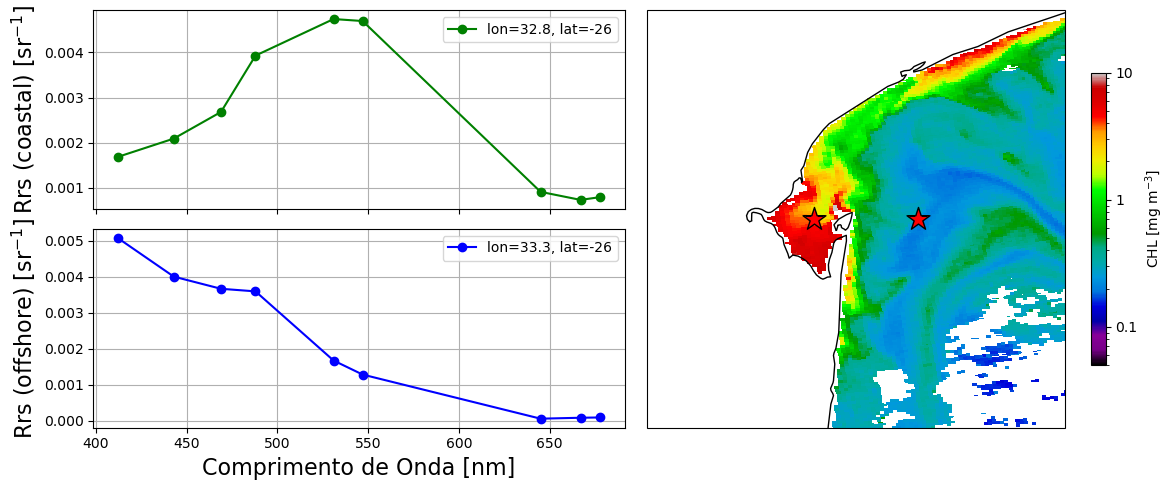

In [7]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12, 5))
gs = axes[0, 1].get_gridspec()
for ax in axes[:, -1]:
    ax.remove()
axm = fig.add_subplot(gs[:, -1], projection=ccrs.PlateCarree())
axm.coastlines()
axm.set_extent((32, 34, -27, -25))
m = axm.pcolormesh(lon, lat, sds, cmap='nipy_spectral', norm=LogNorm(0.05, 10))
cb = fig.colorbar(m, format='%g', shrink=0.7)
cb.ax.set_ylabel('CHL [mg m$^{-3}$]')

px0, py0 = points['lon'][0], points['lat'][0]
px1, py1 = points['lon'][1], points['lat'][1]
inshore.plot(x='wavelength', y='pixel_value', color='g', ax=axes[0, 0], marker='o', label=f"lon={px0}, lat={py0}")
offshore.plot(x='wavelength', y='pixel_value', color='b', ax=axes[1, 0], marker='o', label=f"lon={px1}, lat={py1}")
axm.scatter(px0, py0, s=300, edgecolors='k', marker='*', c='r')
axm.scatter(px1, py1, s=300, edgecolors='k', marker='*', c='r')

axes[0, 0].set_ylabel('Rrs (coastal) [sr$^{-1}$]', size=16)
axes[1, 0].set_ylabel('Rrs (offshore) [sr$^{-1}$]', size=16)
axes[1, 0].set_xlabel('Comprimento de Onda [nm]', size=16)
axes[0, 0].grid('on')
axes[1, 0].grid('on')

fig.tight_layout()

[⬆️ Voltar ao topo](#conteudos)

<a id="download"></a>

## Obter dados online através do Copernicus Marine Toolbox (M2D2)

In [8]:
variables = ["CHL", "CHL_uncertainty", "flags"]
if not Path.home().joinpath('.copernicusmarine/.copernicusmarine-credentials').is_file():
	auth = copernicusmarine.login()
dataset_id = "cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M"

# Download the data
copernicusmarine.subset(
    dataset_id=dataset_id,
    minimum_longitude=bbox[0],
    maximum_longitude=bbox[2],
    minimum_latitude=bbox[1],
    maximum_latitude=bbox[3],
    start_datetime='2024-01-01T00:00:00',
    end_datetime='2024-12-31T23:59:59',
    variables=variables,
    output_directory="L3",
    skip_existing=True
)

print("Sucesso!")

INFO - 2025-09-23T15:37:58Z - Selected dataset version: "202411"
INFO - 2025-09-23T15:37:58Z - Selected dataset part: "default"


Sucesso!


<a id="sazonal"></a>

## Variação sazonal e espacial de uma variável

Text(0, 0.5, 'CHL [mg m$^{-3}$]')

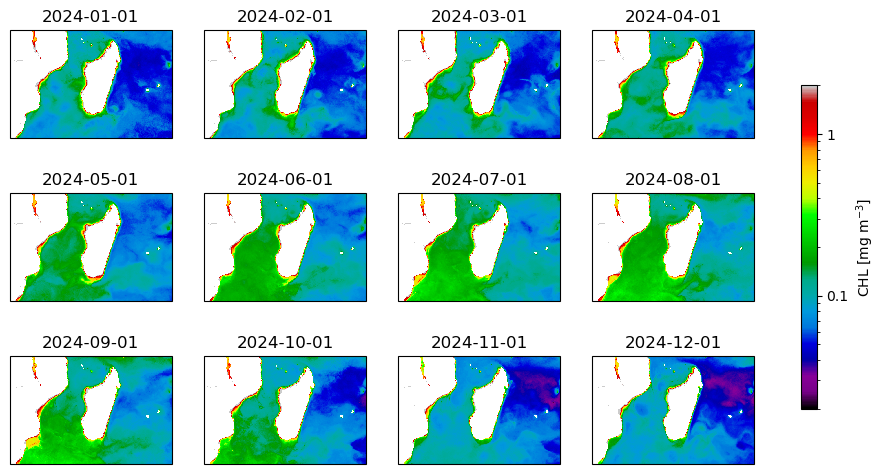

In [9]:
file_path, = list(Path('L3').glob('cmems_obs*.nc'))
chl = xr.open_dataset(file_path)

fig, axes = plt.subplots(3, 4, figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()})
for i, ax in enumerate(axes.flatten()):
  data = chl.isel(time=i)
  m = ax.pcolormesh(data.longitude, data.latitude, data.CHL, cmap='nipy_spectral', norm=LogNorm(0.02, 2))
  ax.set_title(str(data.time.values)[:10])
cb = fig.colorbar(m, format='%g', shrink=0.7, ax=axes.flatten())
cb.ax.set_ylabel('CHL [mg m$^{-3}$]')  

<a id="series"></a>

## Séries temporais de duas variáveis e suas relações

In [10]:
variables = ["to", "zo", "ugo", "vgo", "so", "mlotst"]
# https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012/download?dataset=dataset-armor-3d-nrt-monthly
dataset_id = "dataset-armor-3d-nrt-monthly"

# Download the data
copernicusmarine.subset(
    dataset_id=dataset_id,
    minimum_longitude=bbox[0],
    maximum_longitude=bbox[2],
    minimum_latitude=bbox[1],
    maximum_latitude=bbox[3],
    start_datetime='2024-01-01T00:00:00',
    end_datetime='2024-12-31T23:59:59',
    variables=variables,
    output_directory="L3",
    skip_existing=True
)
print("Sucesso!")

INFO - 2025-09-23T15:38:29Z - Selected dataset version: "202012"
INFO - 2025-09-23T15:38:29Z - Selected dataset part: "default"


Sucesso!


In [11]:
def get_path(bbox: dict):
    from matplotlib.path import Path as mPath
    
    x0, x1 = bbox['lon']
    y0, y1 = bbox['lat']
    # path vertex coordinates
    vertices = [
        (x0, y0),  # left, bottom
        (x0, y1),  # left, top
        (x1, y1),  # right, top
        (x1, y0),  # right, bottom
        (x0, y0),  # ignored
    ]
    return mPath(vertices)

In [12]:
def extract_area(da, key, bbox: dict):
	lon, lat = da.longitude.values, da.latitude.values
	path = get_path(bbox=bbox)
	if len(lon.shape) == 1:
		x, y = np.meshgrid(lon, lat)
	else:
		x, y = lon, lat
	points = np.vstack((x.ravel(), y.ravel())).T
	mask = path.contains_points(points)
	mask = np.array(mask).reshape(x.shape)

	df = []
	columns = ['time', 'pixel_count', 'valid', 'invalid', 'min', 'max', 'mean', 'median', 'std']
	for t in da.time:
		values = da.sel(time=t)[key].values
		masked = values[mask]
		valid = np.ma.compressed(masked)
		valid_px = valid.size
		total_px = masked.size
		invalid_px = total_px - valid_px
		if valid_px == 0:
			mean = dstd = dmax = dmin = dmed = np.nan
		else:
			mean = valid.mean()
			dstd = valid.std()
			dmax = valid.max()
			dmin = valid.min()
			dmed = np.median(valid)			
		df.append([t.values, total_px, valid_px, invalid_px, dmin, dmax, mean, dmed, dstd])
	return pd.DataFrame(df, columns=columns)


In [13]:
file_path, = list(Path('L3').glob('dataset-armor*.nc'))
sst = xr.open_dataset(file_path)


In [14]:
region = {'lon': [33, 33.5], 'lat': [-25.5, -26]}
chl_extract = extract_area(chl, 'CHL', region)
sst_extract = extract_area(sst.sel(depth=0), 'to', region)
sst_extract

,time,pixel_count,valid,invalid,min,max,mean,median,std
0,2024-01-01,4,4,0,26.726,27.004,26.84050,26.8160,0.118513
1,2024-02-01,4,4,0,27.399,27.718,27.58750,27.6165,0.131538
2,2024-03-01,4,4,0,27.034,27.332,27.16875,27.1545,0.106530
3,2024-04-01,4,4,0,25.730,26.333,26.07625,26.1210,0.224370
4,2024-05-01,4,4,0,25.311,25.865,25.64575,25.7035,0.205128
5,2024-06-01,4,4,0,22.806,23.467,23.07775,23.0190,0.242167
6,2024-07-01,4,4,0,22.640,23.480,22.97450,22.8890,0.313930
7,2024-08-01,4,4,0,22.440,23.166,22.68450,22.5660,0.283617
8,2024-09-01,4,4,0,22.803,23.498,23.28700,23.4235,0.284764
9,2024-10-01,4,4,0,22.763,22.998,22.85900,22.8375,0.092954


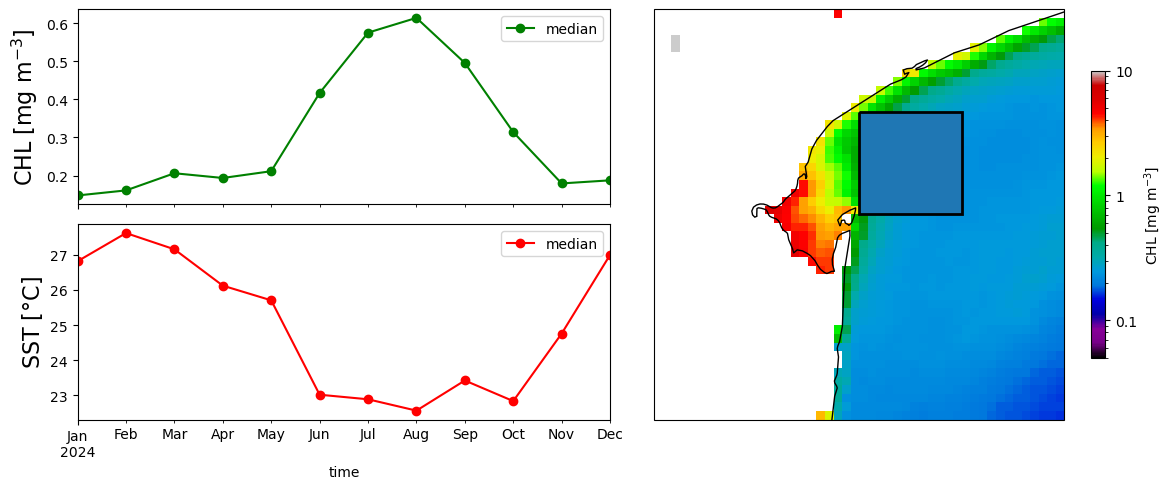

In [15]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12, 5))
gs = axes[0, 1].get_gridspec()
for ax in axes[:, -1]:
    ax.remove()
axm = fig.add_subplot(gs[:, -1], projection=ccrs.PlateCarree())
axm.coastlines()
axm.set_extent((32, 34, -27, -25))

log_da = np.ma.log10(chl.CHL.values)
mean = log_da.mean(axis=0)

m = axm.pcolormesh(chl.longitude, chl.latitude, 10**mean, cmap='nipy_spectral', norm=LogNorm(0.05, 10))
cb = fig.colorbar(m, format='%g', shrink=0.7)
cb.ax.set_ylabel('CHL [mg m$^{-3}$]')

chl_extract.plot(x='time', y='median', color='g', ax=axes[0, 0], marker='o')
sst_extract.plot(x='time', y='median', color='r', ax=axes[1, 0], marker='o')

path = get_path(bbox=region)
patch = patches.PathPatch(path, lw=2)
axm.add_patch(patch)

axes[0, 0].set_ylabel('CHL [mg m$^{-3}$]', size=16)
axes[1, 0].set_ylabel('SST [$\degree$C]', size=16)

fig.tight_layout()



## Exercícios de Consolidação

1. Repita o exercício de extração de séries temporais comparativas, mas desta vez usando **um ponto específico** em vez de uma área.
2. Compare a variação temporal entre **um ponto costeiro** e **um ponto em mar aberto**. Quais as diferenças que observa?
3. Explique a possível razão para a diferença na quantidade de **fitoplâncton (clorofila)** e **temperatura da superfície do mar** entre essas duas regiões.
4. Discuta porque a variação da **temperatura** costuma ser **oposta à da clorofila**.

<div class="alert alert-warning" style="border-radius:5px" role="alert">
Exercício de avaliação por submeter até as 23:59 do quinto (5) dia da semana 2.
</div>

## Alguns Recursos
1. [ECOP Training](https://github.com/Elgyii/ocean-colour-training-ecops-africa)